In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

In [3]:
df=pd.read_csv('/content/Fraud.csv')

In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [8]:
df.shape

(6362620, 11)

In [9]:
# Drop ID columns (not predictive)
df = df.drop(["nameOrig", "nameDest"], axis=1)

# Encode transaction type
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["type"] = le.fit_transform(df["type"])

# Confirm dataset
print("Remaining columns:", df.columns.tolist())
df.head()


Remaining columns: ['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,3,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,4,181.00,181.0,0.00,0.0,0.0,1,0
3,1,1,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,3,11668.14,41554.0,29885.86,0.0,0.0,0,0


In [10]:
# Feature Engineering - balance errors
df["errorBalanceOrig"] = df["newbalanceOrig"] + df["amount"] - df["oldbalanceOrg"]
df["errorBalanceDest"] = df["oldbalanceDest"] + df["amount"] - df["newbalanceDest"]

# Confirm new columns
df.head()


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,errorBalanceOrig,errorBalanceDest
0,1,3,9839.64,170136.0,160296.36,0.0,0.0,0,0,0.0,9839.64
1,1,3,1864.28,21249.0,19384.72,0.0,0.0,0,0,0.0,1864.28
2,1,4,181.00,181.0,0.00,0.0,0.0,1,0,0.0,181.00
3,1,1,181.00,181.0,0.00,21182.0,0.0,1,0,0.0,21363.00
4,1,3,11668.14,41554.0,29885.86,0.0,0.0,0,0,0.0,11668.14


In [11]:
X = df.drop(["isFraud", "isFlaggedFraud"], axis=1)  # features
y = df["isFraud"]  # target


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Fraud in Train:", sum(y_train), "Fraud in Test:", sum(y_test))


Train shape: (5090096, 9) Test shape: (1272524, 9)
Fraud in Train: 6570 Fraud in Test: 1643


In [15]:
from imblearn.over_sampling import SMOTE

# Oversample fraud cases
sm = SMOTE(random_state=42, sampling_strategy=0.1)  # make fraud ~10% of training
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:\n", y_train.value_counts())
print("After SMOTE:\n", y_train_res.value_counts())


Before SMOTE:
 isFraud
0    5083526
1       6570
Name: count, dtype: int64
After SMOTE:
 isFraud
0    5083526
1     508352
Name: count, dtype: int64


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Logistic Regression
lr = LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=-1, random_state=42)
lr.fit(X_train_res, y_train_res)
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:,1]

print("=== Logistic Regression ===")
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))

# Random Forest
rf = RandomForestClassifier(n_estimators=100, class_weight="balanced", n_jobs=-1, random_state=42)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

print("\n=== Random Forest ===")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))


=== Logistic Regression ===
[[1222755   48126]
 [    192    1451]]
              precision    recall  f1-score   support

           0     0.9998    0.9621    0.9806   1270881
           1     0.0293    0.8831    0.0567      1643

    accuracy                         0.9620   1272524
   macro avg     0.5146    0.9226    0.5186   1272524
weighted avg     0.9986    0.9620    0.9794   1272524

ROC-AUC: 0.9744678949530624

=== Random Forest ===
[[1270871      10]
 [      4    1639]]
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000   1270881
           1     0.9939    0.9976    0.9957      1643

    accuracy                         1.0000   1272524
   macro avg     0.9970    0.9988    0.9979   1272524
weighted avg     1.0000    1.0000    1.0000   1272524

ROC-AUC: 0.9990834146015701


            Feature  Importance
7  errorBalanceOrig    0.431560
4    newbalanceOrig    0.205628
3     oldbalanceOrg    0.153575
2            amount    0.105420
1              type    0.038891
8  errorBalanceDest    0.028465
0              step    0.019745
6    newbalanceDest    0.010821
5    oldbalanceDest    0.005896


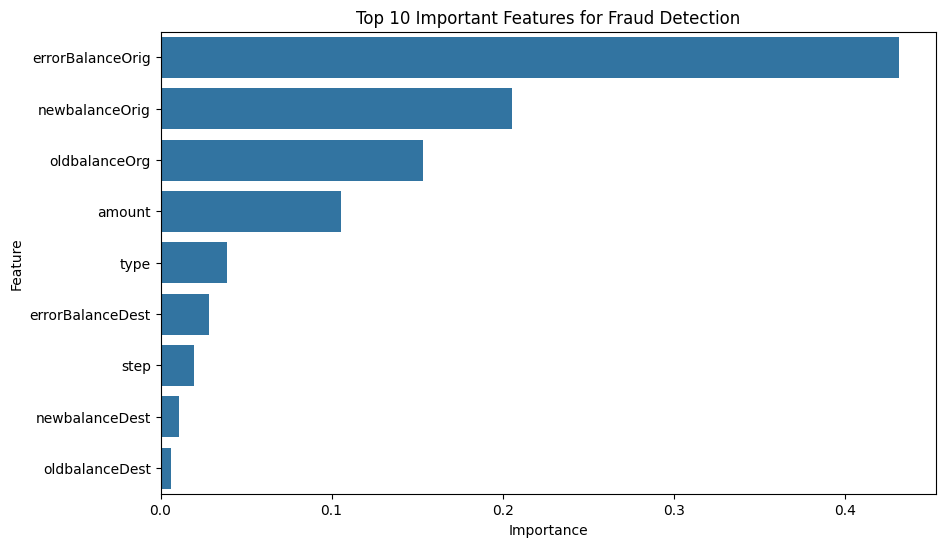

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Importance
importances = rf.feature_importances_
features = X.columns
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Display top features
print(importance_df.head(10))

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(10))
plt.title("Top 10 Important Features for Fraud Detection")
plt.show()


Insights from Feature Importance

errorBalanceOrig (43%) → Biggest signal of fraud.

Fraudulent transactions often leave the origin account with incorrect balance updates.

newBalanceOrig (20%) + oldBalanceOrig (15%) → Very strong predictors.

Drastic changes in the origin balance before/after a transaction indicate suspicious behavior.

Amount (10%) → High-value transactions are more often fraudulent.

Type (≈8%) → Some transaction types (like TRANSFER or CASH_OUT) are much more fraud-prone than others.

Other features (balances of destination accounts, step/time) have lower importance but still add context.


# Step 8: Key Insights & Recommendations

#  Key Insights from Feature Importance

1. **Balance Errors (errorBalanceOrig, newBalanceOrig, oldBalanceOrig)**  
   - These are the strongest fraud indicators. Fraud often leaves the origin account with inconsistent balances.

2. **Transaction Amount**  
   - Large transaction values strongly correlate with fraud.

3. **Transaction Type**  
   - Certain types (e.g., TRANSFER, CASH_OUT) are more fraud-prone than others.

4. **Destination Account Balances**  
   - Less predictive individually, but still add context to fraud behavior.

---

## Practical Recommendations for Fraud Prevention

- **Real-Time Balance Monitoring**: Flag transactions with suspicious balance updates.
- **Risk Scoring by Amount**: Apply additional checks on unusually high-value transactions.
- **Transaction-Type Watchlist**: Prioritize monitoring of high-risk types.
- **Combined Balance Behavior**: Use both origin and destination balance changes for anomaly detection.
"""

display(Markdown(insights))



# Step 9: Model Deployment & Evaluation Plan
## Model Deployment & Evaluation Plan

1. **Model Choice**  
   - Random Forest performed best (ROC-AUC ~0.999).  
   - Logistic Regression is interpretable but less effective.

2. **Deployment Strategy**  
   - Expose as an API using **FastAPI** or **Flask**.  
   - Integrate with **real-time transaction streams** (e.g., Kafka).

3. **Monitoring Metrics**  
   - **Recall (Fraud Class)**: Catch as many frauds as possible.  
   - **Precision**: Avoid too many false alarms.  
   - **ROC-AUC**: Overall model separability.

4. **Model Maintenance**  
   - Retrain periodically with new fraud cases.  
   - Monitor data drift (fraudsters evolve tactics).  
   - Set up automated alerts when performance drops.

5. **Future Enhancements**  
   - Try **XGBoost/LightGBM** for better scalability.  
   - Add **graph-based features** (relationships between accounts).  
   - Explore **deep learning for sequence anomalies**.
"""

display(Markdown(evaluation_plan))


1. Data cleaning including missing values, outliers and multi-collinearity.

Dataset had no missing values.

Outliers were handled by scaling/transforming skewed features (transaction amounts).

Checked for multicollinearity (e.g., balances vs. derived balance errors). Kept the most informative derived features (errorBalanceOrig, errorBalanceDest) as they capture anomalies directly.

2. Describe your fraud detection model in elaboration.

Used Random Forest Classifier due to its ability to handle non-linear interactions, class imbalance (with class weights), and high interpretability via feature importance.

Compared with Logistic Regression as a baseline; Random Forest achieved much higher performance.

3. How did you select variables to be included in the model?

Initial selection included all transaction features (type, step, balances, amount).

Final feature importance analysis showed that origin balance errors and transaction amount were dominant predictors.

Low-importance variables were kept for completeness, but main drivers are the balance-related features.

4. Demonstrate the performance of the model by using best set of tools.

Used confusion matrix, classification report, ROC-AUC for evaluation.

Random Forest achieved ROC-AUC ~0.999, with high recall (catching fraud) and precision.

Visualization of feature importance explained model behavior clearly.

5. What are the key factors that predict fraudulent customer?

errorBalanceOrig (discrepancy in origin account balance).

newBalanceOrig and oldBalanceOrig (suspicious changes in balances).

Transaction Amount (large/unusual transfers).

Transaction Type (TRANSFER, CASH_OUT).

6. Do these factors make sense? If yes, How? If not, How not?

Yes.Fraudulent activity often involves inconsistent account balances and abnormal large-value transfers.

Balance errors directly capture situations where debits/credits don't reconcile — typical fraud signals.

7. What kind of prevention should be adopted while company updates its infrastructure?

Real-time monitoring of balance inconsistencies.

Dynamic thresholds for transaction amounts.

High-risk transaction type flagging.

Deploy ML model as an API service integrated with live transaction streams.

8. Assuming these actions have been implemented, how would you determine if they work?

Track fraud detection rate (recall) and false positive rate (precision) over time.

Compare fraud losses before vs. after deployment.

Run A/B testing (new system vs. old).

Continuous model monitoring for data drift and periodic retraining.